In [1]:
import os
from comet_ml.api import API

#comet_api = API(os.environ["COMETML_API_KEY"])
comet_api = API("MsvugnKUBPUYhFjSK8iIg2vzw")


In [2]:
exps = {
    "peteish32": comet_api.get_experiments("ai2", "peteish32", "peteish32"),
    "peteish13": comet_api.get_experiments("ai2", "olmo-2-1124-13b", "OLMo-2-1124-13B-stage-1"),
}

print(repr({k: len(v) for k, v in exps.items()}))

{'peteish32': 27, 'peteish13': 75}


In [5]:
from tqdm.notebook import tqdm

def download_metric(exps, metric_name):
    result = {}
    for exp in tqdm(exps):
        metrics = exp.get_metrics(metric_name)
        for values in metrics:
            result[values['step']] = float(values['metricValue'])
    result = dict(sorted(result.items()))
    return result

loss = {
    name: download_metric(es, "train/CE loss")
    for name, es in exps.items()
}

skipped_steps = {
    name: download_metric(es, "optim/step skipped")
    for name, es in exps.items()
}

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

## Training Loss

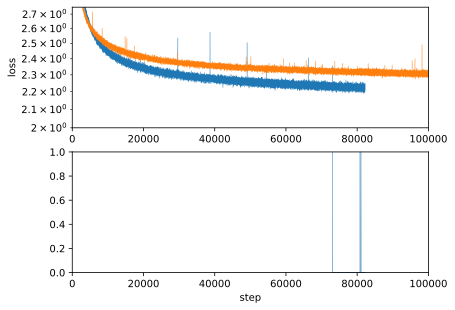

Steps skipped for the 32B: 6
[73018, 73020, 73022, 73024, 80788, 81072]


In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np

fig, axs = plt.subplots(nrows=2)

# loss
for name, values in loss.items():
    xs = np.array(list(values.keys()))
    ys = np.array(list(values.values()))
    axs[0].semilogy(xs, ys, linewidth=0.5)
axs[0].set_ylim(2.0, 2.75)
axs[0].set_xlim(0, 100000)
axs[0].set_ylabel("loss")

# steps skipped
for name, values in skipped_steps.items():
    xs = np.array(list(values.keys()))
    ys = np.array(list(values.values()))
    axs[1].plot(xs, ys, linewidth=0.5)
axs[1].set_ylim(0, 1)
axs[1].set_xlim(0, 100000)

plt.xlabel("step")
plt.show()

print(f"Steps skipped for the 32B: {int(sum(skipped_steps['peteish32'].values()))}")
print([step for step, value in skipped_steps['peteish32'].items() if value > 0])

## Spike Analysis

Steps with spikes: [29645 38677 49089 54503 66257 73032 73033]


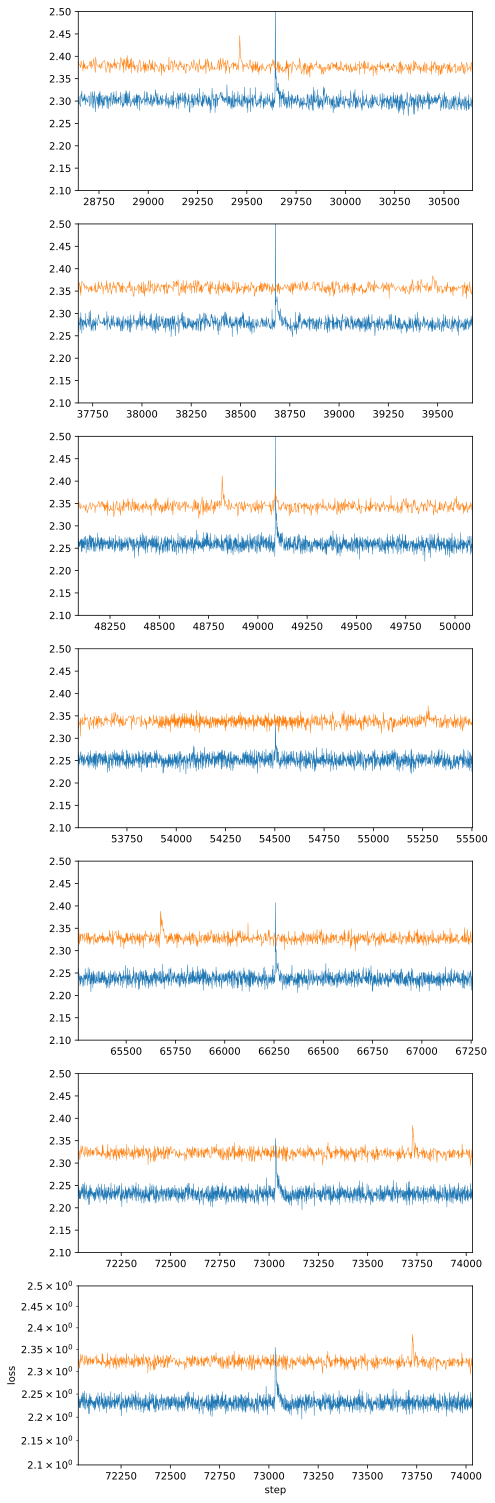

In [19]:
window_size = 128
losses = np.array(list(loss["peteish32"].values()))
steps = np.array(list(loss["peteish32"].keys()))

from numpy.lib.stride_tricks import sliding_window_view
windows = sliding_window_view(losses, window_size)

stds = windows.std(axis=1)
means = windows.mean(axis=1)
losses = losses[window_size - 1 :]
steps = steps[window_size - 1 :]
spike_steps = steps[np.argwhere(losses > means + stds * 6)].flatten()
print(f"Steps with spikes: {spike_steps}")

fig, axes = plt.subplots(
    nrows=len(spike_steps),
    figsize=(7, len(spike_steps)*3),
    sharex=False
)

for ax, spike in zip(axes, spike_steps):
    for name, values in loss.items():
        xs = np.array(list(values.keys()))
        ys = np.array(list(values.values()))
        ax.plot(xs, ys, linewidth=0.5)
    ax.set_ylim(2.1, 2.5)
    ax.set_xlim(spike-1000, spike+1000)
    plt.yscale('log')
    plt.xlabel("step")
    plt.ylabel("loss")

plt.tight_layout()
plt.show()
